In [44]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import dask.dataframe as dd
import warnings
import glob
import matplotlib.transforms as mt
plt.rcParams.update({'font.size': 16})

In [53]:
df = dd.read_parquet("/mnt/data2/SDO/AIA/dask_parquet", columns=['NSPIKES','WAVELNTH','GAEZ_OBS','GAEX_OBS','GAEY_OBS','EXPTIME','QUALITY','DATAMEAN'])

In [56]:
year_start = 2018; year_end = 2019
month_start = 1; month_end = 12
day_start = 1; day_end = 30
start_d = "{}-{}-{}".format(year_start,str(month_start).zfill(2),str(day_start).zfill(2)); 
end_d = "{}-{}-{}".format(year_end,str(month_end).zfill(2),str(day_end).zfill(2)) 
cadence = '{}min'.format(1) #change to 15 minutes
start_d, end_d

df_sdo = df.loc['2017-12-30 23:55:00':'2019-01-01 00:00:00'].compute()

In [57]:
df_sdo.head()

,NSPIKES,WAVELNTH,GAEZ_OBS,GAEX_OBS,GAEY_OBS,EXPTIME,QUALITY,DATAMEAN
T_OBS,,,,,,,,
2017-12-30 23:55:00.570000+00:00,25596,94,-10023524.99,39742225.71,-9917867.72,2.900833,0x00000000,1.0818
2017-12-30 23:55:02.070000+00:00,36747,335,-10026801.15,39742209.12,-9914626.31,2.900814,0x00000000,1.0530
2017-12-30 23:55:05.840000+00:00,8709,193,-10035040.69,39742165.28,-9906473.09,2.000048,0x00000000,128.7360
2017-12-30 23:55:06.590000+00:00,35386,304,-10036670.63,39742156.26,-9904860.05,2.902045,0x00000000,4.8180
2017-12-30 23:55:08.070000+00:00,24825,131,-10039911.54,39742137.96,-9901652.56,2.901340,0x00000000,5.1812


In [58]:
# SDO
df_sdo = df_sdo.loc[(df_sdo['QUALITY'] == '0x00000000') & (df_sdo['EXPTIME'] < 6) & (df_sdo['EXPTIME'] > 0.5) & ((df_sdo['WAVELNTH'] == 304) | (df_sdo['WAVELNTH'] == 193))]
df_sdo.head()

,NSPIKES,WAVELNTH,GAEZ_OBS,GAEX_OBS,GAEY_OBS,EXPTIME,QUALITY,DATAMEAN
T_OBS,,,,,,,,
2017-12-30 23:55:05.840000+00:00,8709,193,-10035040.69,39742165.28,-9906473.09,2.000048,0x00000000,128.7360
2017-12-30 23:55:06.590000+00:00,35386,304,-10036670.63,39742156.26,-9904860.05,2.902045,0x00000000,4.8180
2017-12-30 23:55:17.840000+00:00,8405,193,-10061257.82,39742005.79,-9880520.66,2.000048,0x00000000,128.7293
2017-12-30 23:55:18.580000+00:00,36516,304,-10062869.22,39741994.99,-9878925.03,2.902044,0x00000000,4.8145
2017-12-30 23:55:29.840000+00:00,8384,193,-10087468.35,39741815.87,-9854559.57,2.000044,0x00000000,128.7356


In [59]:
df_sdo['NSPIKES_EXP'] = df_sdo['NSPIKES'] / df_sdo['EXPTIME']


In [60]:
y, x = np.histogram(np.log10(df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES_EXP'].to_numpy()), bins=200)
x=(x[1:]+x[:-1])/2
len(y), len(x)

(200, 200)

In [61]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


expected=(2.6,.2, 50000, 4, 0.8, 70000)
params,cov=curve_fit(bimodal, x, y,expected)

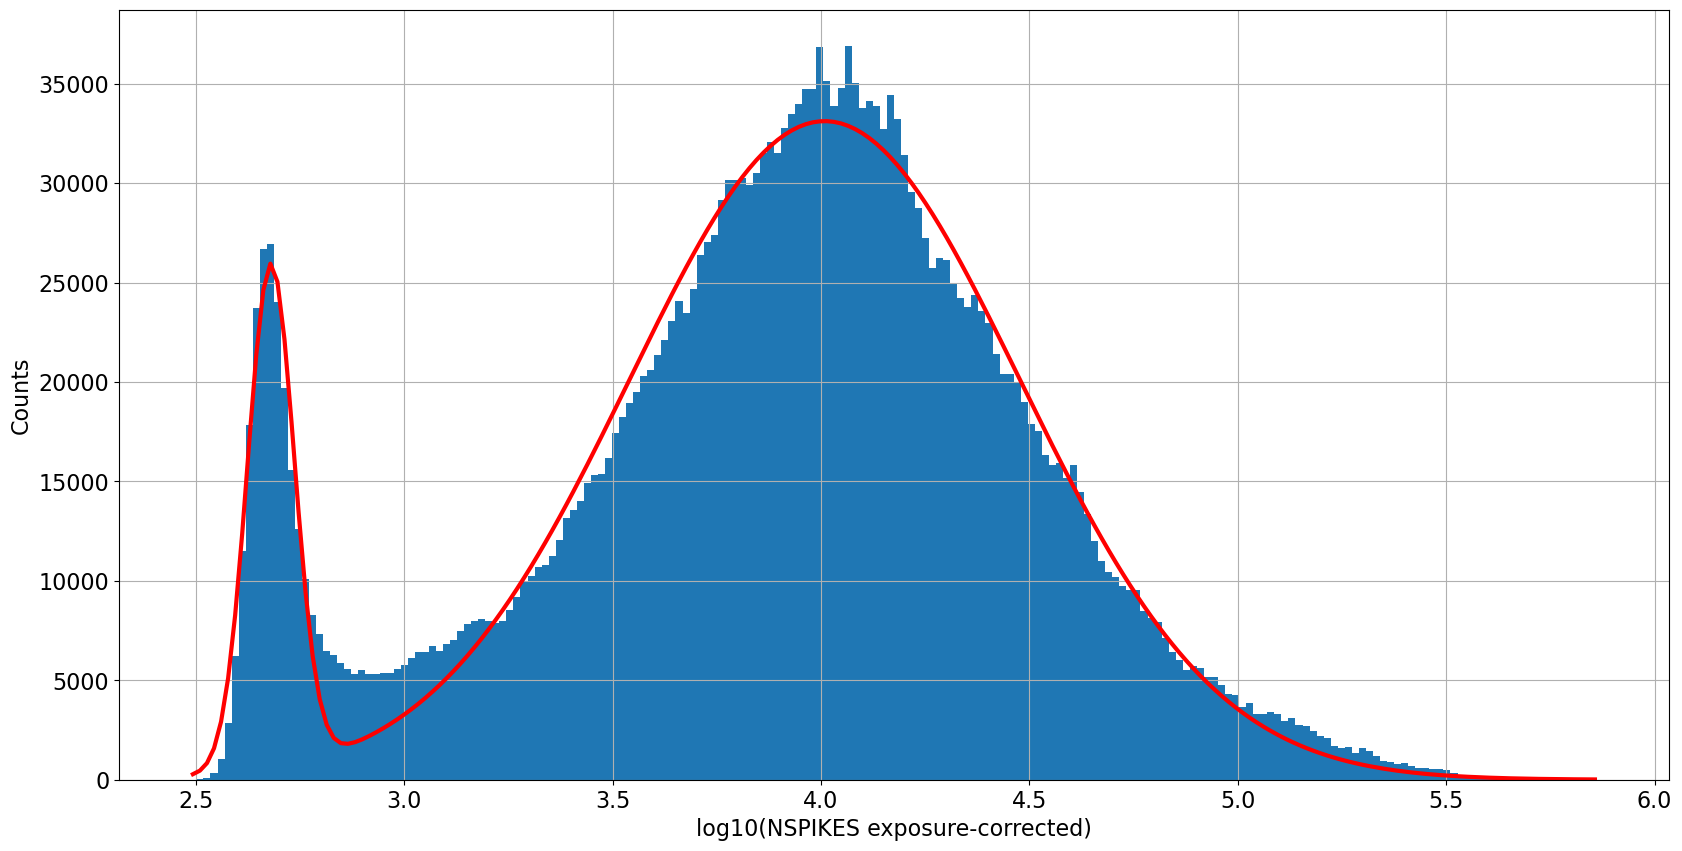

In [62]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.hist(np.log10(df_sdo[df_sdo['WAVELNTH'] == 304]['NSPIKES_EXP']),bins=200);

sigma=np.sqrt(np.diag(cov))
plt.plot(x, bimodal(x,*params), color='red', lw=3, label='model')

# ax.axvline(1.5, color='gray')
ax.set_xlabel('log10(NSPIKES exposure-corrected)')
ax.set_ylabel('Counts')
plt.grid()

## Look at 304

In [63]:
w = 304
df_sdo_w = df_sdo[df_sdo['WAVELNTH'] == w]

In [64]:
nspikes_daily_mean = df_sdo_w['NSPIKES_EXP'].resample('1D').mean()
nspikes_daily_min = df_sdo_w['NSPIKES_EXP'].resample('1D').min()

In [65]:
threshold = 1500
low_v_idx = df_sdo_w[df_sdo_w['NSPIKES_EXP'] < threshold].index

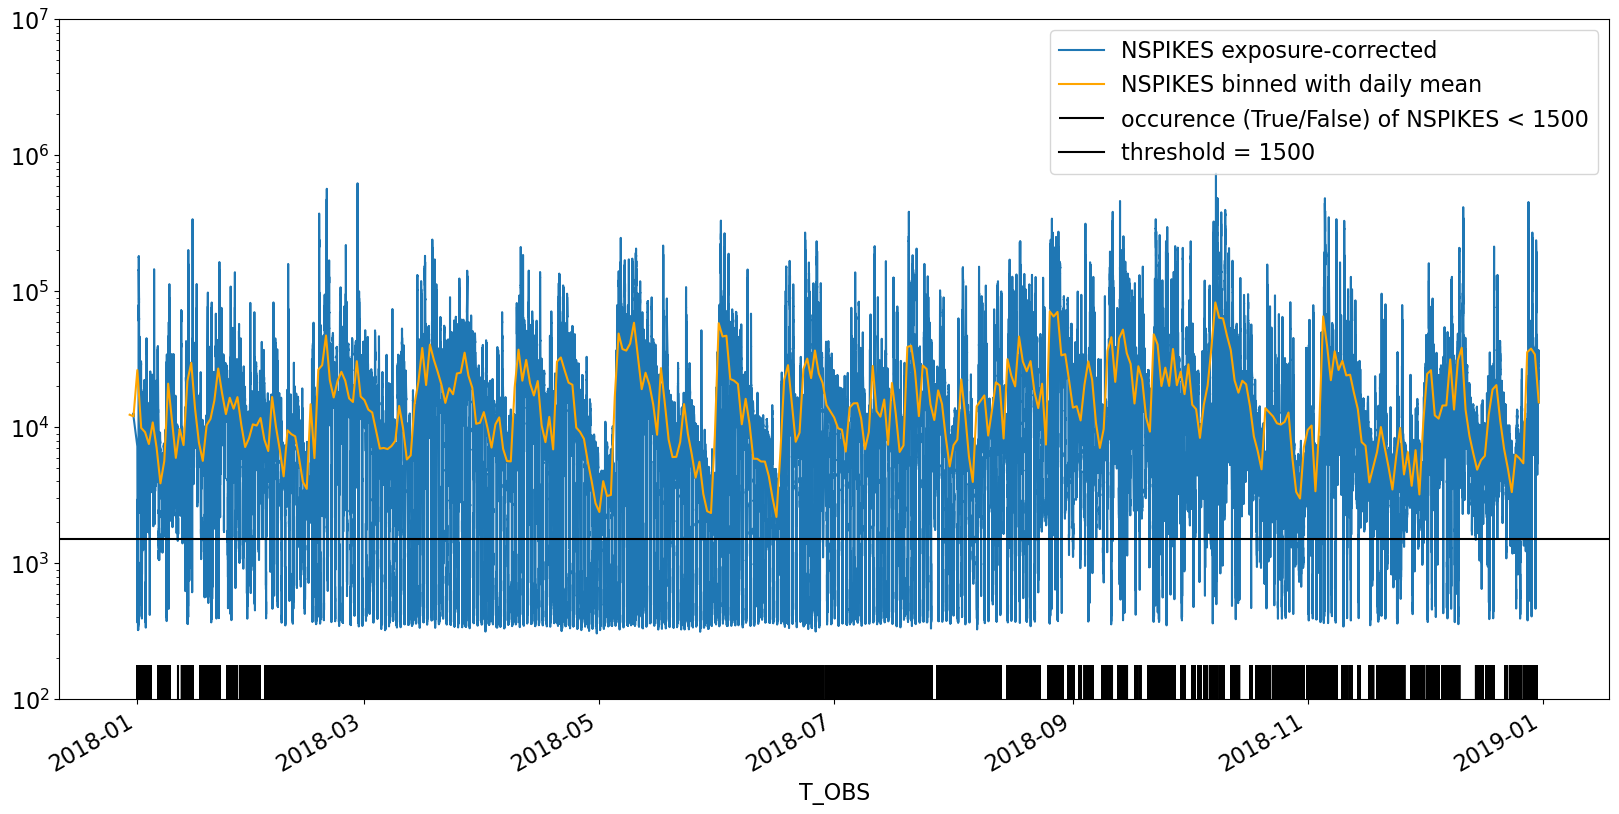

In [66]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})


fig, ax = plt.subplots(1, 1, figsize=(20,10))
df_sdo_w['NSPIKES_EXP'].plot(logy=True, ax=ax, label='NSPIKES exposure-corrected')
nspikes_daily_mean.plot(logy=True, color='orange', ax=ax, label='NSPIKES binned with daily mean')

trans = mt.blended_transform_factory(ax.transData, ax.transAxes)
ax.vlines(low_v_idx, ymin=0, ymax=0.05, color='black', transform=trans, label=f'occurence (True/False) of NSPIKES < {threshold}')
ax.axhline(y = threshold, color='black', label=f'threshold = {threshold}')

ax.set_ylim([1e2, 1e7])
plt.legend(loc = 'upper right')

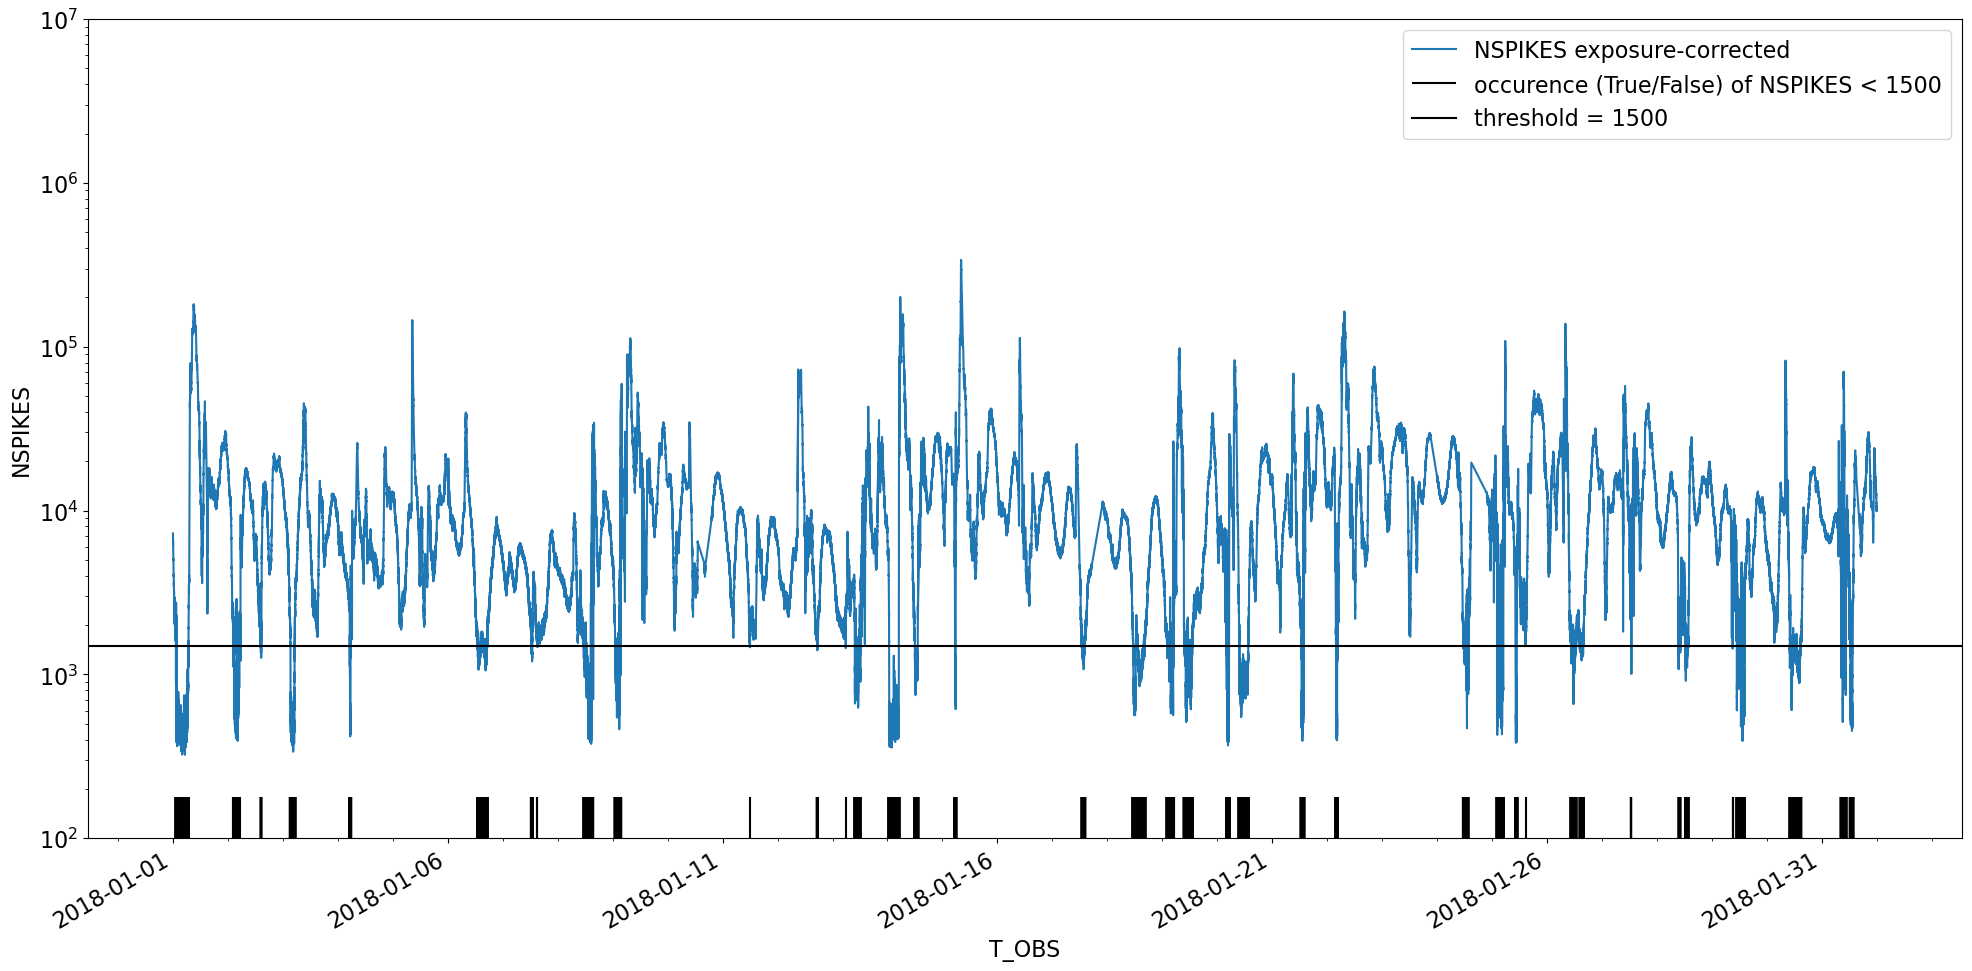

In [180]:
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams.update({'font.size': 16})

threshold = 1500
df_sdo_month = df_sdo_w.loc['2018-01-01':'2018-01-31']
low_v_idx = df_sdo_month[df_sdo_month['NSPIKES_EXP'] < threshold].index

fig, ax = plt.subplots(1, 1, figsize=(20,10))
df_sdo_month['NSPIKES_EXP'].plot(logy=True, ax=ax, label='NSPIKES exposure-corrected')
trans = mt.blended_transform_factory(ax.transData, ax.transAxes)
ax.vlines(low_v_idx, ymin=0, ymax=0.05, color='black', transform=trans, label=f'occurence (True/False) of NSPIKES < {threshold}')
ax.axhline(y = threshold, color='black', label=f'threshold = {threshold}')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.set_ylabel('NSPIKES')
ax.set_ylim([1e2, 1e7])
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('spikes_1month.png')

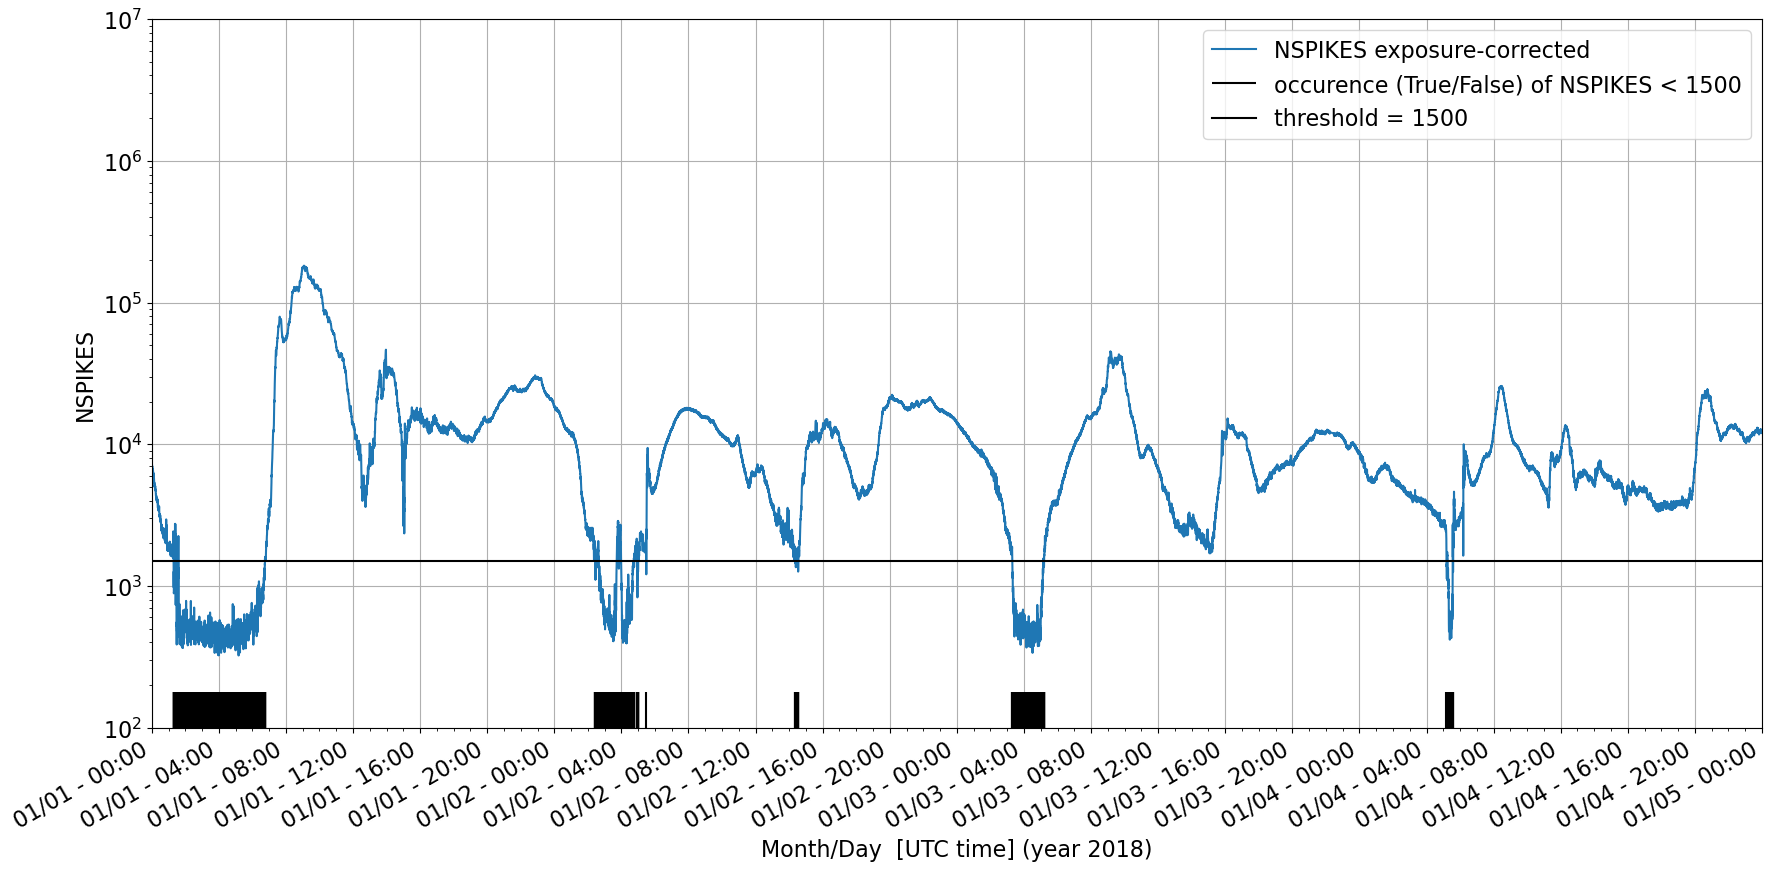

In [181]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})

threshold = 1500
df_sdo_days = df_sdo_w.loc['2018-01-01':'2018-01-05']
low_v_idx = df_sdo_days[df_sdo_days['NSPIKES_EXP'] < threshold].index

fig, ax = plt.subplots(1, 1, figsize=(18,9))
df_sdo_days['NSPIKES_EXP'].plot(logy=True, ax=ax, label='NSPIKES exposure-corrected')
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))
trans = mt.blended_transform_factory(ax.transData, ax.transAxes)
ax.vlines(low_v_idx, ymin=0, ymax=0.05, color='black', transform=trans, label=f'occurence (True/False) of NSPIKES < {threshold}')
ax.axhline(y = threshold, color='black', label=f'threshold = {threshold}')
ax.set_ylabel('NSPIKES')
ax.set_xlabel('Month/Day  [UTC time] (year 2018)')
ax.set_xlim(['2018-01-01 00:00:00', '2018-01-05 00:00:00'])
ax.set_ylim([1e2, 1e7])
plt.legend(loc = 'upper right')
plt.grid()
plt.tight_layout()
plt.savefig('spikes_4days.png')

In [155]:
# Export the NSPIKES and coordinates to CSV
df_sdo_month.drop(['QUALITY'], axis=1).to_hdf('sdo_spikes_w304_4days.h5', 'spikes')
df_sdo_month.head()

,NSPIKES,WAVELNTH,GAEZ_OBS,GAEX_OBS,GAEY_OBS,EXPTIME,QUALITY,DATAMEAN,NSPIKES_EXP
T_OBS,,,,,,,,,
2018-10-02 00:00:06.580000+00:00,13437,304,28764686.29,1784151.18,-30771395.97,2.900830,0x00000000,4.1673,4632.122530
2018-10-02 00:00:18.580000+00:00,13604,304,28753796.05,1818460.54,-30779577.35,2.900835,0x00000000,4.1682,4689.684177
2018-10-02 00:00:30.580000+00:00,14055,304,28742891.41,1852746.49,-30787729.41,2.900829,0x00000000,4.1662,4845.166675
2018-10-02 00:00:42.580000+00:00,13675,304,28731962.93,1887038.69,-30795859.22,2.900836,0x00000000,4.1705,4714.158263
2018-10-02 00:00:54.570000+00:00,13191,304,28721021.74,1921302.31,-30803958.52,2.900831,0x00000000,4.1717,4547.317648


In [71]:
from sscws.sscws import SscWs
from sscws.coordinates import CoordinateComponent, CoordinateSystem,SurfaceGeographicCoordinates
from sscws.outputoptions import CoordinateOptions, BFieldTraceOptions,\
    DistanceFromOptions, LocationFilter, OutputOptions, RegionOptions,\
    ValueOptions
from sscws.request import DataRequest, SatelliteSpecification
from sscws.timeinterval import TimeInterval

ssc = SscWs()

In [162]:
coord_options = [
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.X),
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.Y),
        CoordinateOptions(CoordinateSystem.GEI_TOD, CoordinateComponent.Z)]

output_options = OutputOptions(
        coord_options,
        None, None,
        RegionOptions(True, True, True, True),
        ValueOptions(True, True, True, True),
        DistanceFromOptions(True, True, True, True)) 

# loc_request_sdo = DataRequest('Getting Data for Spyros', TimeInterval('2018-01-01T00:00:00Z','2018-01-05T00:00:00Z'),
#                              [SatelliteSpecification('sdo',2)], None, output_options, None, None, None)

loc_request_sdo = DataRequest('Getting Data for Spyros', TimeInterval('2018-01-01T00:00:00Z','2018-01-31T00:00:00Z'),
                             [SatelliteSpecification('sdo',1)], None, output_options, None, None, None)

results = ssc.get_locations(loc_request_sdo)

In [163]:
result_sdo = results['Data'][0]
result_sdo.keys()

dict_keys(['Id', 'Coordinates', 'Time', 'BTraceData', 'RadialLength', 'MagneticStrength', 'NeutralSheetDistance', 'BowShockDistance', 'MagnetoPauseDistance', 'DipoleLValue', 'DipoleInvariantLatitude', 'SpacecraftRegion', 'BGseX', 'BGseY', 'BGseZ', 'RadialTracedFootpointRegions', 'NorthBTracedFootpointRegions', 'SouthBTracedFootpointRegions'])

In [164]:
result_sdo['Time'][0:5]

array([datetime.datetime(2018, 1, 1, 0, 0, tzinfo=tzutc()),
       datetime.datetime(2018, 1, 1, 0, 1, tzinfo=tzutc()),
       datetime.datetime(2018, 1, 1, 0, 2, tzinfo=tzutc()),
       datetime.datetime(2018, 1, 1, 0, 3, tzinfo=tzutc()),
       datetime.datetime(2018, 1, 1, 0, 4, tzinfo=tzutc())], dtype=object)

In [165]:
x_sdo = result_sdo['Coordinates'][0]['X']
y_sdo = result_sdo['Coordinates'][0]['Y']
z_sdo = result_sdo['Coordinates'][0]['Z']

In [166]:
for k in result_sdo.keys():
    print(len(result_sdo[k]))

3
1
43201
0
43201
43201
43201
43201
43201
43201
43201
43201
43201
43201
43201
43201
43201
43201


In [167]:
dforb = pd.DataFrame.from_dict({'Time':result_sdo['Time'], 
                                'GEIX':x_sdo, 'GEIY':y_sdo, 'GEIZ':z_sdo, 'BGSEX':result_sdo['BGseX'], 'BGSEY':result_sdo['BGseY'], 'BGSEZ':result_sdo['BGseZ'], 
                                'RadialLength':result_sdo['RadialLength'], 'MagneticStrength':result_sdo['MagneticStrength'], 
                                'NeutralSheetDistance':result_sdo['NeutralSheetDistance'], 'BowShockDistance':result_sdo['BowShockDistance'], 
                                'MagnetoPauseDistance':result_sdo['MagnetoPauseDistance'], 'DipoleLValue':result_sdo['DipoleLValue'], 
                                'DipoleInvariantLatitude':result_sdo['DipoleInvariantLatitude']}).set_index('Time')
dforb.head()

,GEIX,GEIY,GEIZ,BGSEX,BGSEY,BGSEZ,RadialLength,MagneticStrength,NeutralSheetDistance,BowShockDistance,MagnetoPauseDistance,DipoleLValue,DipoleInvariantLatitude
Time,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,39748.020172,-3466.508090,-13649.164438,-26.687496,86.500586,67.860491,42168.963419,113.135406,-1.000000e+31,-68719.724977,-34873.845603,6.853306,67.543106
2018-01-01 00:01:00+00:00,39739.804268,-3294.624090,-13715.609312,-26.782769,87.010961,67.426016,42168.999632,113.289415,-1.000000e+31,-68819.889249,-34934.296149,6.857703,67.550705
2018-01-01 00:02:00+00:00,39730.832577,-3122.676909,-13781.790733,-26.882302,87.518308,66.988716,42169.039877,113.444262,-1.000000e+31,-68920.136409,-34995.158183,6.862127,67.558334
2018-01-01 00:03:00+00:00,39721.093178,-2950.670123,-13847.709894,-26.986087,88.022674,66.548658,42169.073582,113.600017,-1.000000e+31,-69020.757238,-35056.441971,6.866576,67.566000
2018-01-01 00:04:00+00:00,39710.600376,-2778.606713,-13913.363218,-27.094106,88.523911,66.105821,42169.113265,113.756551,-1.000000e+31,-69121.741315,-35117.881036,6.871051,67.573710


In [175]:
# Need to resample and merge with the SDO NSPIKES dataframe
df_select = df_sdo_w[['NSPIKES_EXP', 'NSPIKES', 'EXPTIME', 'GAEX_OBS', 'GAEY_OBS', 'GAEZ_OBS']]
print(df_select.loc['2018-01-01':'2018-01-31'].head())
df_select = df_select.reindex(dforb.index)
print(df_select.head())

                                  NSPIKES_EXP  NSPIKES   EXPTIME     GAEX_OBS  \
T_OBS                                                                           
2018-01-01 00:00:06.580000+00:00  7245.560298    21027  2.902053  39703132.91   
2018-01-01 00:00:18.580000+00:00  7072.921455    20526  2.902054  39701615.25   
2018-01-01 00:00:30.580000+00:00  7210.065698    20924  2.902054  39700066.79   
2018-01-01 00:00:42.580000+00:00  7055.000681    20474  2.902055  39698488.70   
2018-01-01 00:00:54.590000+00:00  7200.419841    20896  2.902053  39696878.73   

                                    GAEY_OBS     GAEZ_OBS  
T_OBS                                                      
2018-01-01 00:00:06.580000+00:00 -8744953.80 -11205056.12  
2018-01-01 00:00:18.580000+00:00 -8718681.40 -11230908.35  
2018-01-01 00:00:30.580000+00:00 -8692395.64 -11256758.55  
2018-01-01 00:00:42.580000+00:00 -8666115.78 -11282587.80  
2018-01-01 00:00:54.590000+00:00 -8639804.84 -11308432.42  
            

In [176]:
def interp_key(data, indexin, indexout):
    tin = (indexin.values - indexin.values[0]).astype(np.int64)
    tout = (indexout.values - indexin.values[0]).astype(np.int64)
    ts = np.interp(tout , tin, data)
    return ts

In [177]:
for k in a.keys():
    df_select[k] = interp_key(df_month[k].values, df_month.index, dforb.index)

dfspikes = pd.concat([df_select, dforb], axis=1)
dfspikes.head()

,NSPIKES_EXP,NSPIKES,EXPTIME,GAEX_OBS,GAEY_OBS,GAEZ_OBS,GEIX,GEIY,GEIZ,BGSEX,BGSEY,BGSEZ,RadialLength,MagneticStrength,NeutralSheetDistance,BowShockDistance,MagnetoPauseDistance,DipoleLValue,DipoleInvariantLatitude
Time,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,7245.926045,21028.061406,2.902053,3.970313e+07,-8.744993e+06,-1.120502e+07,39748.020172,-3466.508090,-13649.164438,-26.687496,86.500586,67.860491,42168.963419,113.135406,-1.000000e+31,-68719.724977,-34873.845603,6.853306,67.543106
2018-01-01 00:01:00+00:00,7115.372631,20649.188490,2.902053,3.969614e+07,-8.627947e+06,-1.132007e+07,39739.804268,-3294.624090,-13715.609312,-26.782769,87.010961,67.426016,42168.999632,113.289415,-1.000000e+31,-68819.889249,-34934.296149,6.857703,67.550705
2018-01-01 00:02:00+00:00,6908.452224,20048.683028,2.902051,3.968757e+07,-8.496366e+06,-1.144906e+07,39730.832577,-3122.676909,-13781.790733,-26.882302,87.518308,66.988716,42169.039877,113.444262,-1.000000e+31,-68920.136409,-34995.158183,6.862127,67.558334
2018-01-01 00:03:00+00:00,6649.580561,19297.434638,2.902053,3.967824e+07,-8.364625e+06,-1.157783e+07,39721.093178,-2950.670123,-13847.709894,-26.986087,88.022674,66.548658,42169.073582,113.600017,-1.000000e+31,-69020.757238,-35056.441971,6.866576,67.566000
2018-01-01 00:04:00+00:00,6457.307189,18739.448333,2.902053,3.966816e+07,-8.232728e+06,-1.170637e+07,39710.600376,-2778.606713,-13913.363218,-27.094106,88.523911,66.105821,42169.113265,113.756551,-1.000000e+31,-69121.741315,-35117.881036,6.871051,67.573710


In [184]:
dfspikes

,NSPIKES_EXP,NSPIKES,EXPTIME,GAEX_OBS,GAEY_OBS,GAEZ_OBS,GEIX,GEIY,GEIZ,BGSEX,BGSEY,BGSEZ,RadialLength,MagneticStrength,NeutralSheetDistance,BowShockDistance,MagnetoPauseDistance,DipoleLValue,DipoleInvariantLatitude
Time,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,7245.926045,21028.061406,2.902053,3.970313e+07,-8.744993e+06,-1.120502e+07,39748.020172,-3466.508090,-13649.164438,-26.687496,86.500586,67.860491,42168.963419,113.135406,-1.000000e+31,-68719.724977,-34873.845603,6.853306,67.543106
2018-01-01 00:01:00+00:00,7115.372631,20649.188490,2.902053,3.969614e+07,-8.627947e+06,-1.132007e+07,39739.804268,-3294.624090,-13715.609312,-26.782769,87.010961,67.426016,42168.999632,113.289415,-1.000000e+31,-68819.889249,-34934.296149,6.857703,67.550705
2018-01-01 00:02:00+00:00,6908.452224,20048.683028,2.902051,3.968757e+07,-8.496366e+06,-1.144906e+07,39730.832577,-3122.676909,-13781.790733,-26.882302,87.518308,66.988716,42169.039877,113.444262,-1.000000e+31,-68920.136409,-34995.158183,6.862127,67.558334
2018-01-01 00:03:00+00:00,6649.580561,19297.434638,2.902053,3.967824e+07,-8.364625e+06,-1.157783e+07,39721.093178,-2950.670123,-13847.709894,-26.986087,88.022674,66.548658,42169.073582,113.600017,-1.000000e+31,-69020.757238,-35056.441971,6.866576,67.566000
2018-01-01 00:04:00+00:00,6457.307189,18739.448333,2.902053,3.966816e+07,-8.232728e+06,-1.170637e+07,39710.600376,-2778.606713,-13913.363218,-27.094106,88.523911,66.105821,42169.113265,113.756551,-1.000000e+31,-69121.741315,-35117.881036,6.871051,67.573710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-30 23:56:00+00:00,9054.282037,26264.755000,2.900810,3.412417e+07,6.427118e+06,-2.393453e+07,34128.816128,15522.354841,-19307.410717,0.525079,123.823980,20.913392,42172.214771,125.578755,-1.000000e+31,-66772.627142,-33861.316439,7.402959,68.436390
2018-01-30 23:57:00+00:00,8668.038152,25144.334443,2.900810,3.403526e+07,6.561281e+06,-2.402459e+07,34039.485455,15681.003332,-19336.929321,0.140726,124.013861,20.445746,42172.233414,125.688050,-1.000000e+31,-66891.894173,-33930.625056,7.406785,68.442245
2018-01-30 23:58:00+00:00,8848.821621,25668.742285,2.900809,3.394570e+07,6.695333e+06,-2.411419e+07,33949.503899,15839.352608,-19366.079569,-0.246971,124.200024,19.979550,42172.253246,125.797017,-1.000000e+31,-67011.664543,-34000.492762,7.410573,68.448030


In [179]:
dfspikes.to_hdf('spikes_2018_01_1month_1min.h5', 'dfspikes')

In [182]:
d = pd.read_hdf('spikes_2018_01_1month_1min.h5')

In [185]:
d.head()

,NSPIKES_EXP,NSPIKES,EXPTIME,GAEX_OBS,GAEY_OBS,GAEZ_OBS,GEIX,GEIY,GEIZ,BGSEX,BGSEY,BGSEZ,RadialLength,MagneticStrength,NeutralSheetDistance,BowShockDistance,MagnetoPauseDistance,DipoleLValue,DipoleInvariantLatitude
Time,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,7245.926045,21028.061406,2.902053,3.970313e+07,-8.744993e+06,-1.120502e+07,39748.020172,-3466.508090,-13649.164438,-26.687496,86.500586,67.860491,42168.963419,113.135406,-1.000000e+31,-68719.724977,-34873.845603,6.853306,67.543106
2018-01-01 00:01:00+00:00,7115.372631,20649.188490,2.902053,3.969614e+07,-8.627947e+06,-1.132007e+07,39739.804268,-3294.624090,-13715.609312,-26.782769,87.010961,67.426016,42168.999632,113.289415,-1.000000e+31,-68819.889249,-34934.296149,6.857703,67.550705
2018-01-01 00:02:00+00:00,6908.452224,20048.683028,2.902051,3.968757e+07,-8.496366e+06,-1.144906e+07,39730.832577,-3122.676909,-13781.790733,-26.882302,87.518308,66.988716,42169.039877,113.444262,-1.000000e+31,-68920.136409,-34995.158183,6.862127,67.558334
2018-01-01 00:03:00+00:00,6649.580561,19297.434638,2.902053,3.967824e+07,-8.364625e+06,-1.157783e+07,39721.093178,-2950.670123,-13847.709894,-26.986087,88.022674,66.548658,42169.073582,113.600017,-1.000000e+31,-69020.757238,-35056.441971,6.866576,67.566000
2018-01-01 00:04:00+00:00,6457.307189,18739.448333,2.902053,3.966816e+07,-8.232728e+06,-1.170637e+07,39710.600376,-2778.606713,-13913.363218,-27.094106,88.523911,66.105821,42169.113265,113.756551,-1.000000e+31,-69121.741315,-35117.881036,6.871051,67.573710
